In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import pandas as pd
import seaborn as sns

In [2]:
from weatherbench2.metrics import MAE, _spatial_average

In [9]:
import graphufs
from graphufs.lineplot import LinePlotter
from graphufs.utils import open_dataset

In [4]:
plt.style.use("graphufs.plotstyle")

In [5]:
fig_dir = "figures"
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [10]:
errors = []
for latent_size in [16, 64, 128, 256]:
    errors.append(
        open_dataset(
            f"/testlfs/latent-size-test-{latent_size:03d}/evaluation/validation/graphufs_vs_replay_240h_deterministic.nc"
        ).expand_dims({
            "latent_size": [latent_size],
        })
    )

errors = xr.concat(errors, dim="latent_size")

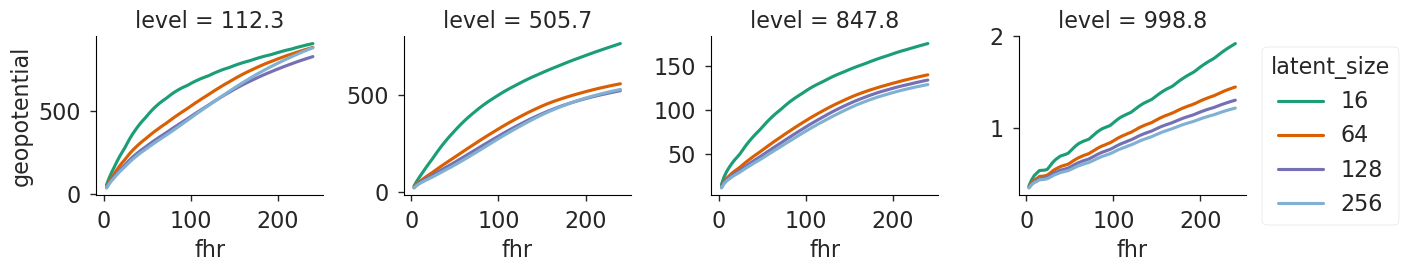

In [38]:
errors.geopotential.sel(metric="mae").sel(level=[100, 500, 800, 1000],method="nearest").plot.line(x="fhr", col="level", sharey=False)

## Plot error by latitude

In [ ]:
serrors = []
for latent_size in [16, 64, 128, 256]:
    serrors.append(
        open_dataset(
            f"/testlfs/latent-size-test-{latent_size:03d}/evaluation/validation/graphufs_vs_replay_240h_deterministic_spatial.nc"
        ).expand_dims({
            "latent_size": [latent_size],
        })
    )

serrors = xr.concat(serrors, dim="latent_size")

In [28]:
def plot_row(axr, xds, metric, field, cmap, level=None):
    kw = {} if level is None else {"level": level}
    for latent_size, ax in zip(xds.latent_size.values, axr):
        plotme = xds[field].sel(
            metric=metric,
            fhr=[6, 24, 48, 24*4, 24*6, 24*8, 24*10],
            latent_size=latent_size,
        ).sel(
            **kw,
            method="nearest",
        ).mean(
            "longitude",
        )
        n_time = len(plotme.fhr)
        for itime in range(n_time):
            plotme.isel(fhr=itime).plot.line(
                x="latitude",
                ax=ax,
                add_legend=False,
                color=plt.get_cmap(cmap)(int(itime/n_time * 256)),
                label=f"{int(plotme.fhr.isel(fhr=itime)): 3d}h",
            )
        sps = ax.get_subplotspec()
        ax.set(
            ylabel="",
            xlabel="Latitude" if sps.is_last_row() else "",
            title=" ".join([x.capitalize() if x != "of" else x for x in field.split("_")]) if sps.is_first_row() else "",
            
        )
    axr[-1].legend(title="Forecast Hour", bbox_to_anchor=(1., .55), loc="center left")

In [31]:
def plot_surface(
    xds,
    metric="mae",
    cmap="plasma",
    field="surface_pressure",
):

    ncols = len(xds.latent_size)
    fig, axs = plt.subplots(1, ncols, figsize=(4*ncols, 4), constrained_layout=True, sharex=True, sharey=True)
    plot_row(axs, xds, metric, field, cmap)
    fig.suptitle(f"{metric.upper()} vs Replay")
    
    return fig, axs

In [36]:
def plot_levels(
    xds,
    metric="mae",
    cmap="plasma",
    fields="geopotential",
    levels=(100, 500, 1000),
):
    nrows = len(levels)
    ncols = len(xds.latent_size)
    fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows), constrained_layout=True, sharex=True)
    for level, axr in zip(levels, axs):
        plot_row(axr, xds, metric, fields, cmap, level=level)
        axr[0].set(ylabel=f"~{int(xds.sel(level=level, method='nearest').level.values)} hPa")
    fig.suptitle(f"{metric.upper()} vs Replay")
    return fig, axs

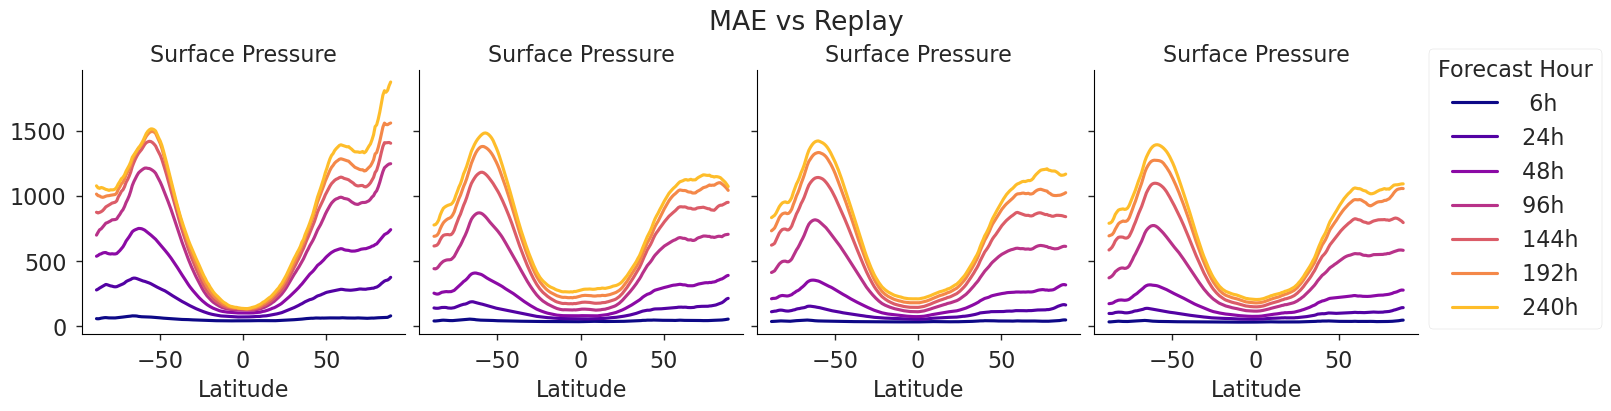

In [34]:
plot_surface(serrors);

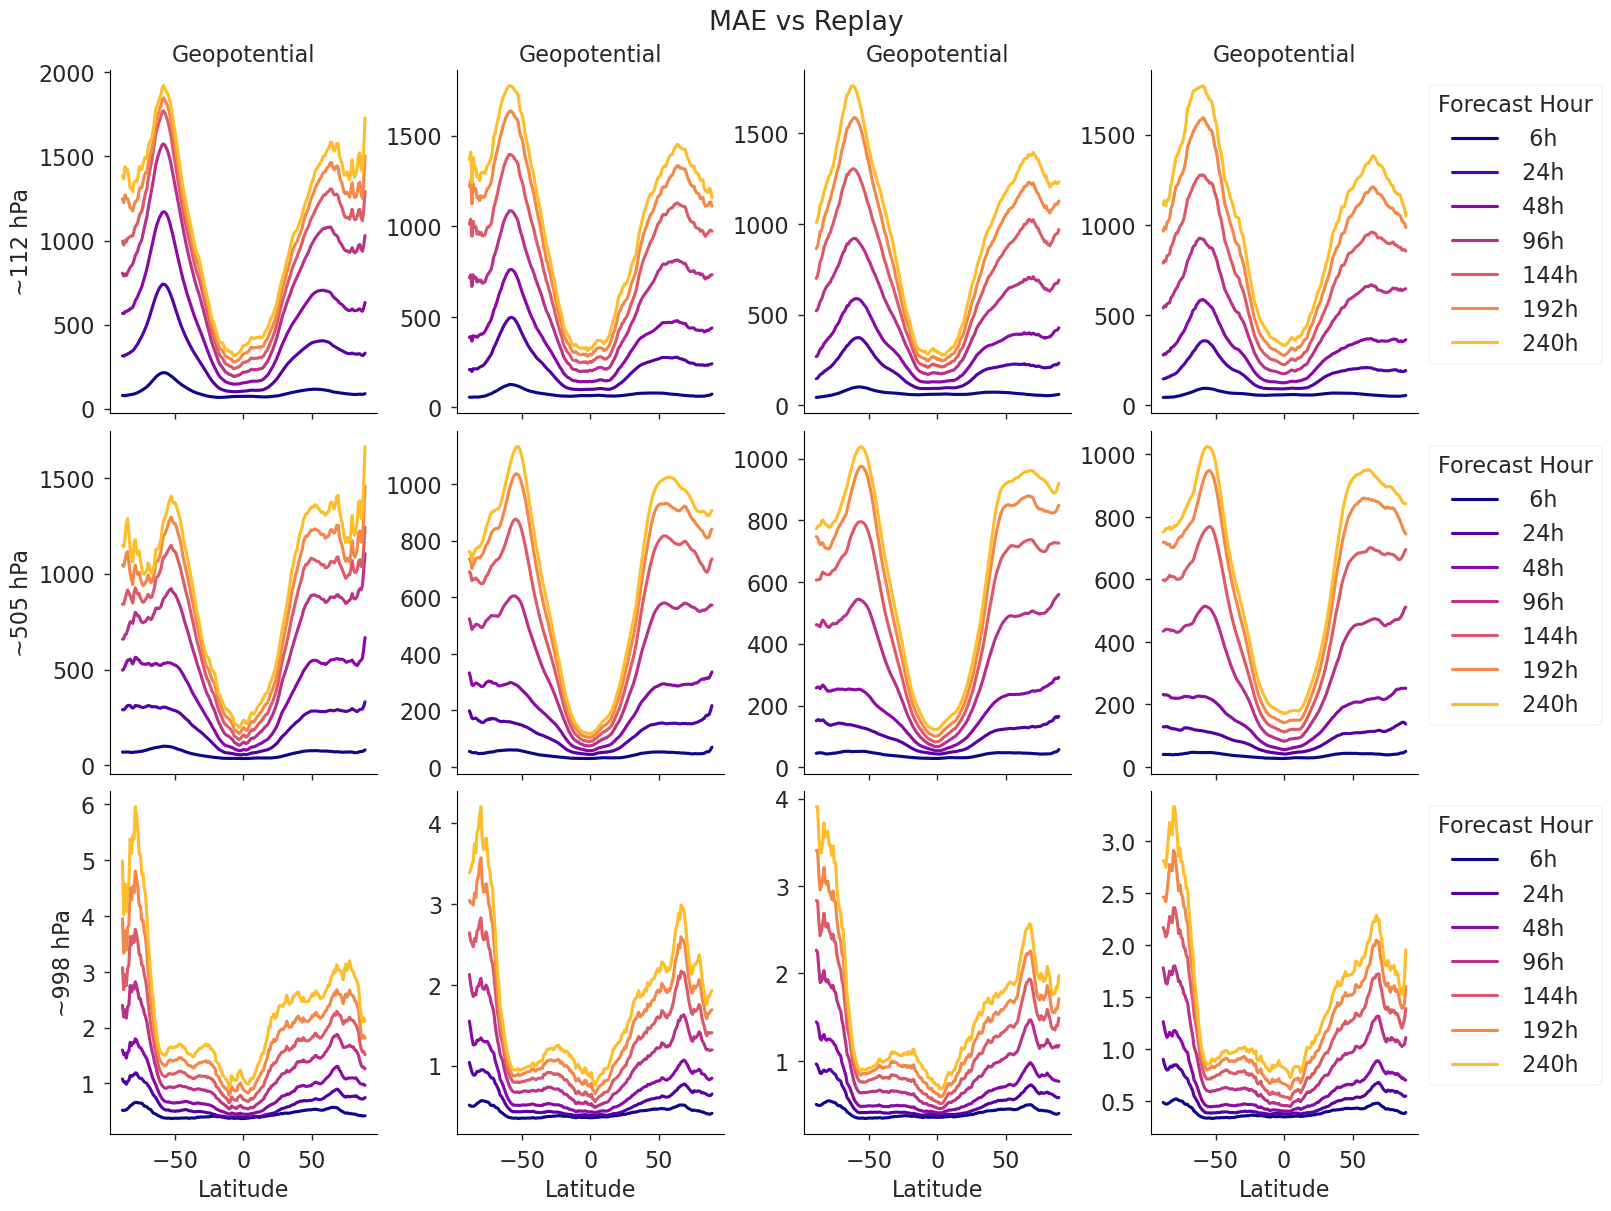

In [37]:
plot_levels(serrors);